# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

# Eval Function - 3 Model Evaluation: MAPE (old), RMSE(old), MDA(new)

In [2]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

def eval(test,pred):
  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_mda = calculate_mda(test, pred)
  print('MDA: ', test_mda)

In [3]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [4]:
def train_test(data):
    test_size = 0.2  # Thay đổi test_size thành 0.2 để có tỉ lệ 8:2

    test_split_idx = int(data.shape[0] * (1 - test_size))

    return data[:test_split_idx], data[test_split_idx:]

# ACB


## Data

In [5]:
df_amz = pd.read_csv("ACB Historical Data.csv")
df_amz

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"10,537.70","10,477.80","10,567.60","10,417.90",7.36M,0.86%
1,12/4/2017,"10,926.90","10,537.70","10,956.80","10,537.70",9.45M,3.69%
2,12/5/2017,"10,477.80","10,956.80","10,956.80","10,477.80",8.19M,-4.11%
3,12/6/2017,"10,447.90","10,447.90","10,627.50","10,328.10",9.81M,-0.29%
4,12/7/2017,"10,837.10","10,447.90","10,837.10","10,447.90",8.30M,3.73%
...,...,...,...,...,...,...,...
1506,12/18/2023,"22,800.00","22,700.00","22,800.00","22,650.00",6.39M,0.22%
1507,12/19/2023,"23,050.00","22,800.00","23,100.00","22,800.00",11.47M,1.10%
1508,12/20/2023,"23,200.00","23,050.00","23,250.00","23,050.00",8.86M,0.65%
1509,12/21/2023,"23,250.00","23,200.00","23,250.00","23,050.00",7.08M,0.22%


## Preprocessing

### Check null and na value

In [6]:
df_amz.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [7]:
df_amz.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [8]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_amz["Vol."] = df_amz["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_amz["Change %"] = df_amz["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_amz['Price'] = df_amz['Price'].apply(convert_str_to_number)
df_amz['Open'] = df_amz['Open'].apply(convert_str_to_number)
df_amz['High'] = df_amz['High'].apply(convert_str_to_number)
df_amz['Low'] = df_amz['Low'].apply(convert_str_to_number)

In [9]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Price column data type: ", type(df_amz['Price'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Vol. column data type: ", type(df_amz['Vol.'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [10]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [11]:
close_amz=df_amz[['Price']]

## EDA

### Get the duration of dataset

In [12]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

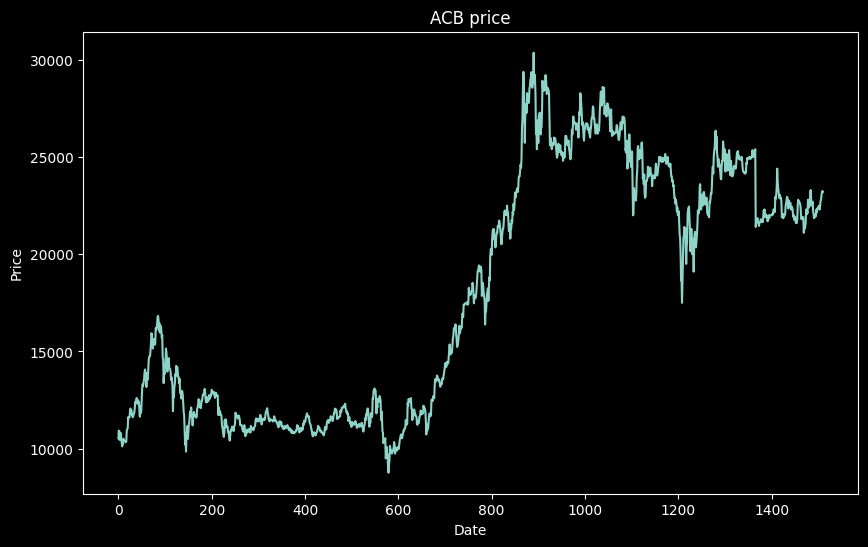

In [13]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_amz)
plt.title('ACB price')
plt.show()

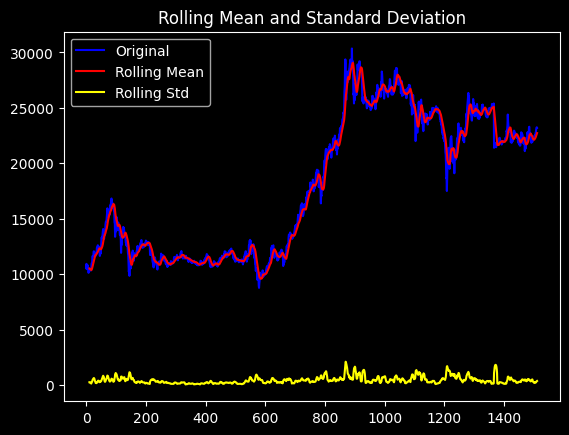

Results of dickey fuller test
Test Statistics                  -1.291961
p-value                           0.632842
No. of lags used                  3.000000
Number of observations used    1507.000000
critical value (1%)              -3.434697
critical value (5%)              -2.863460
critical value (10%)             -2.567792
dtype: float64


In [14]:
test_stationarity(close_amz)

## Train, test

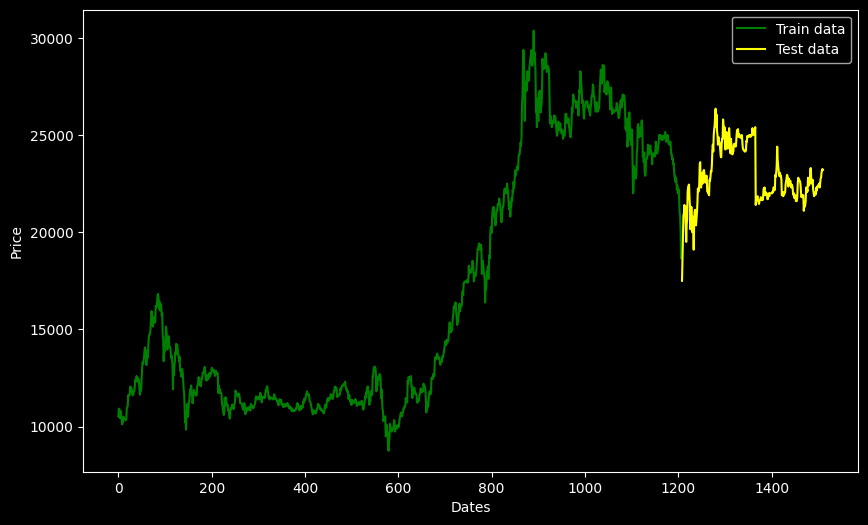

In [15]:
close_amz = close_amz.reset_index(drop=True)

#train_data, test_data, valid_data = train_test_valid(close_amz)
train_data, test_data = train_test(close_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
#plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [16]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [17]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_amz[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27100.328, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25479.097, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=17654.694, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=17649.208, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=17651.189, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=17651.189, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=17653.156, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=17650.855, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=17648.193, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17653.785, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1208
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -8819.096
Date:                Sat, 23 Dec 2023   AIC                          17648.193
Time:                        11:56:49   BIC                          17673.676
Sample:                             0   HQIC                         17657.789
                               - 1208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.9983     59.964      0.684      0.494     -76.528     158.525
ar.L1          0.0502      0.037      1.349      0.177      -0.023       0.123
ar.L2          0.9471      0.037     25.465      0.000       0.874       1.020
ma.L1          0.9220      0.044     20.818      0.000       0.835       1.009
sigma2      1.275e+05   2725.504     46.764      0.000    1.22e+05    1.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1458.82
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.35   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [18]:
model = ARIMA(y_train, order=(1,0,1),exog=df_amz[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1208
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7833.718
Date:                Sat, 23 Dec 2023   AIC                          15681.436
Time:                        11:56:50   BIC                          15717.113
Sample:                             0   HQIC                         15694.871
                               - 1208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6223     15.621     -0.104      0.917     -32.239      28.994
High           0.8408      0.013     62.384      0.000       0.814       0.867
Open          -0.6254      0.015    -42.989      0.000      -0.654      -0.597
Low            0.7839      0.011     68.802      0.000       0.762       0.806
ar.L1         -0.8193      0.078    -10.474      0.000      -0.973      -0.666
ma.L1          0.7560      0.087      8.716      0.000       0.586       0.926
sigma2      2.509e+04    587.018     42.736      0.000    2.39e+04    2.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2536.30
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [19]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_amz[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [20]:
eval(y_test,y_pred)

MAPE:  0.5661551516727712
RMSE:  178.86323405770244
MDE:  68.54304635761589


## Forecast

In [21]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_amz[['High','Open','Low']][last_index-333:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1511    22433.647146
1512    22363.182385
1513    22811.391267
1514    23363.857174
1515    23241.029045
1516    22716.063471
1517    22649.518955
1518    22641.438667
1519    22575.616681
1520    22332.954045
1521    21891.189321
1522    21918.576268
1523    21894.792086
1524    22277.622874
1525    22165.120308
1526    21819.684549
1527    22330.430132
1528    22213.284790
1529    22141.780018
1530    22372.911828
1531    22430.805753
1532    22318.303187
1533    22357.499598
1534    22368.269052
1535    22598.956971
1536    22753.941233
1537    22727.759549
1538    23035.038908
1539    23200.792623
1540    23106.987571
Name: predicted_mean, dtype: float64


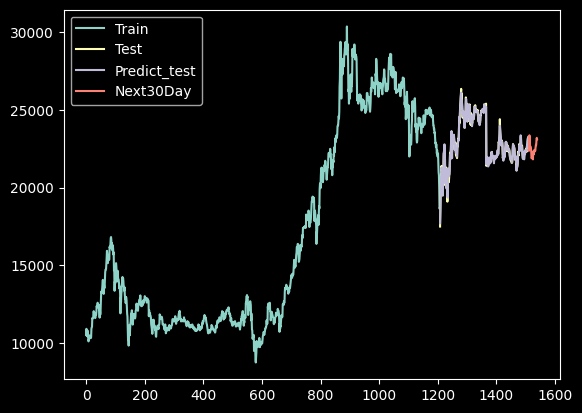

In [22]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()

# PVS

## Data

In [23]:
df_PVS = pd.read_csv("PVS Historical Data.csv")
df_PVS

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"17,292.00","16,746.00","17,474.00","16,655.00",12.03M,4.40%
1,12/4/2017,"17,838.00","17,383.00","17,838.00","17,383.00",6.60M,3.16%
2,12/5/2017,"17,292.00","18,020.00","18,020.00","17,292.00",6.46M,-3.06%
3,12/6/2017,"17,565.00","17,201.00","17,656.00","16,837.00",8.73M,1.58%
4,12/7/2017,"17,110.00","17,383.00","17,474.00","17,019.00",6.10M,-2.59%
...,...,...,...,...,...,...,...
1511,12/18/2023,"37,400.00","37,500.00","38,000.00","37,400.00",1.84M,-0.27%
1512,12/19/2023,"37,900.00","37,600.00","37,900.00","37,100.00",2.54M,1.34%
1513,12/20/2023,"38,400.00","37,900.00","38,600.00","37,900.00",3.04M,1.32%
1514,12/21/2023,"38,200.00","37,400.00","38,700.00","37,400.00",1.44M,-0.52%


## Preprocessing

### Check null and na value

In [24]:
df_PVS.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [25]:
df_PVS.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [26]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_PVS["Vol."] = df_PVS["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_PVS["Change %"] = df_PVS["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_PVS['Price'] = df_PVS['Price'].apply(convert_str_to_number)
df_PVS['Open'] = df_PVS['Open'].apply(convert_str_to_number)
df_PVS['High'] = df_PVS['High'].apply(convert_str_to_number)
df_PVS['Low'] = df_PVS['Low'].apply(convert_str_to_number)

In [27]:
print("Date column data type: ", type(df_PVS['Date'][0]))
print("Open column data type: ", type(df_PVS['Open'][0]))
print("Price column data type: ", type(df_PVS['Price'][0]))
print("High column data type: ", type(df_PVS['High'][0]))
print("Low column data type: ", type(df_PVS['Low'][0]))
print("Vol. column data type: ", type(df_PVS['Vol.'][0]))
print("Volume column data type: ", type(df_PVS['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [28]:
df_PVS['Date'] = pd.to_datetime(df_PVS.Date)

### Choose X

In [29]:
close_PVS=df_PVS[['Price']]

## EDA

### Get the duration of dataset

In [30]:
print("Starting date: ",df_PVS.iloc[0][0])
print("Ending date: ", df_PVS.iloc[-1][0])
print("Duration: ", df_PVS.iloc[-1][0]-df_PVS.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

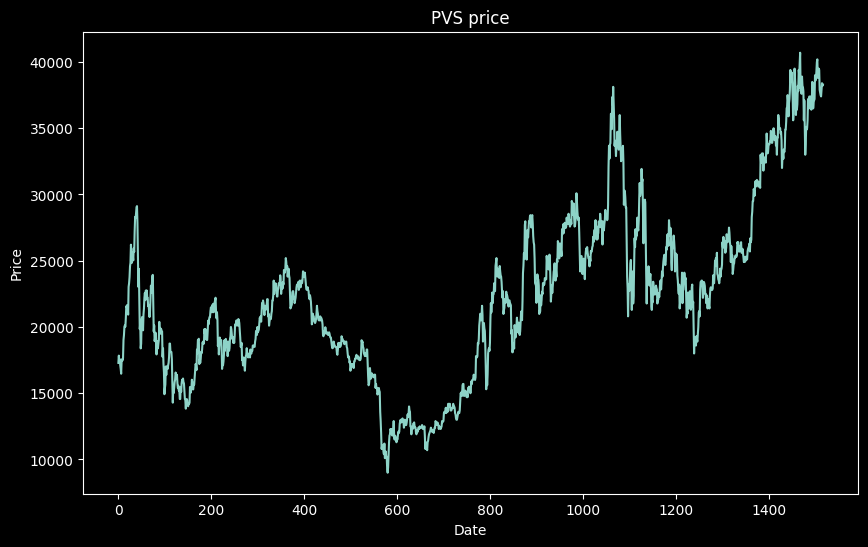

In [31]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_PVS)
plt.title('PVS price')
plt.show()

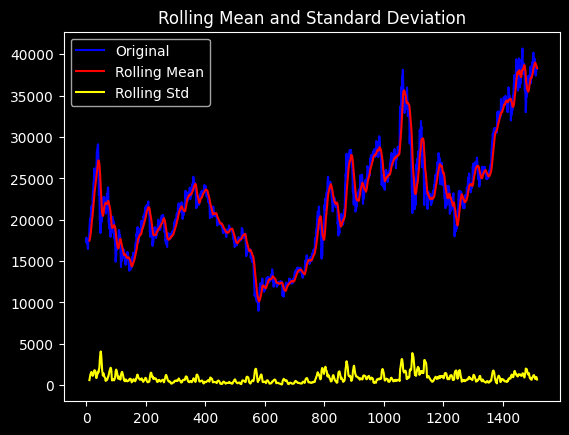

Results of dickey fuller test
Test Statistics                  -1.541720
p-value                           0.512781
No. of lags used                  0.000000
Number of observations used    1515.000000
critical value (1%)              -3.434674
critical value (5%)              -2.863450
critical value (10%)             -2.567787
dtype: float64


In [32]:
test_stationarity(close_PVS)

## Train, test

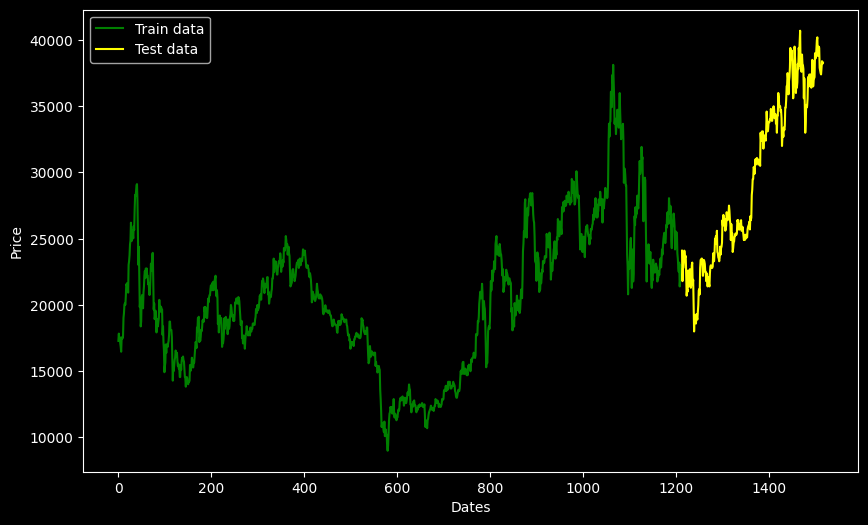

In [33]:
close_PVS = close_PVS.reset_index(drop=True)

train_data, test_data= train_test(close_PVS)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [34]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [35]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_PVS[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27586.961, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25954.768, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19370.216, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19368.622, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19373.843, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19373.848, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19372.086, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=19373.631, Time=0.69 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19363.642, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19363.427, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22748.234, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1212
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9677.713
Date:                Sat, 23 Dec 2023   AIC                          19363.427
Time:                        11:56:54   BIC                          19383.827
Sample:                             0   HQIC                         19371.108
                               - 1212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    192.7526     94.568      2.038      0.042       7.402     378.103
ar.L1          0.9906      0.004    253.035      0.000       0.983       0.998
ma.L1          0.0097      0.020      0.493      0.622      -0.029       0.048
sigma2      5.041e+05   1.36e+04     37.027      0.000    4.77e+05    5.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               393.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [36]:
model = ARIMA(y_train, order=(3,0,2),exog=df_PVS[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1212
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -8752.113
Date:                Sat, 23 Dec 2023   AIC                          17524.227
Time:                        11:56:54   BIC                          17575.227
Sample:                             0   HQIC                         17543.429
                               - 1212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        119.3925     37.995      3.142      0.002      44.924     193.861
High           0.7970      0.013     60.921      0.000       0.771       0.823
Open          -0.5613      0.014    -40.144      0.000      -0.589      -0.534
Low            0.7550      0.014     53.032      0.000       0.727       0.783
ar.L1         -0.0751      1.307     -0.057      0.954      -2.636       2.486
ar.L2          0.0026      1.280      0.002      0.998      -2.506       2.511
ar.L3          0.0198      0.184      0.107      0.914      -0.342       0.381
ma.L1         -0.0764      1.309     -0.058      0.953      -2.643       2.490
ma.L2          0.0017      1.179      0.001      0.999      -2.310       2.313
sigma2      1.092e+05   2722.365     40.097      0.000    1.04e+05    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1205.05
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [37]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_PVS[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [38]:
eval(y_test,y_pred)

MAPE:  1.1263606863064652
RMSE:  412.916348905594
MDE:  63.03630363036304


## Forecast

In [39]:
last_index =  close_PVS.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_PVS[['High','Open','Low']][last_index-334:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1516    36646.541198
1517    36846.432502
1518    37546.107474
1519    37332.793731
1520    36848.415360
1521    36378.020102
1522    36124.576257
1523    37583.564527
1524    37972.140185
1525    37421.683252
1526    36380.830365
1527    37126.255965
1528    36811.656196
1529    38746.393519
1530    39012.794544
1531    38851.412630
1532    39338.368635
1533    40456.144888
1534    39261.445268
1535    38662.228915
1536    38599.124236
1537    39004.397855
1538    38656.184929
1539    37817.732777
1540    37882.061111
1541    37740.050207
1542    37593.840960
1543    37231.507705
1544    38225.023355
1545    38207.867832
Name: predicted_mean, dtype: float64


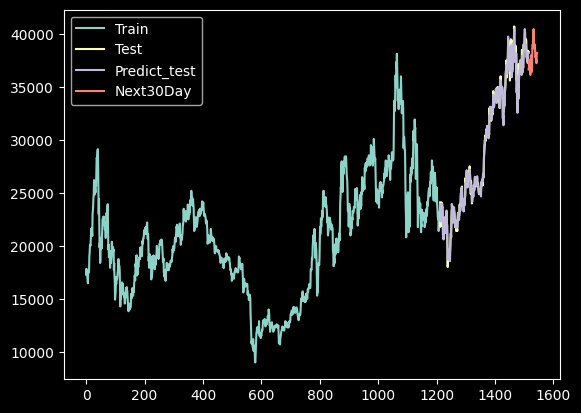

In [40]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()

# VNM

## Data

In [41]:
df_VNM = pd.read_csv("VNM Historical Data.csv")
df_VNM

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"159,039.00","151,736.00","159,039.00","151,736.00",1.50M,4.98%
1,12/4/2017,"164,719.00","159,039.00","166,423.00","159,039.00",1.70M,3.57%
2,12/5/2017,"161,473.00","164,719.00","166,342.00","160,662.00",852.08K,-1.97%
3,12/6/2017,"158,227.00","158,227.00","159,850.00","151,898.00",1.14M,-2.01%
4,12/7/2017,"150,924.00","158,227.00","160,580.00","150,924.00",1.43M,-4.62%
...,...,...,...,...,...,...,...
1509,12/18/2023,"67,000.00","68,100.00","68,200.00","67,000.00",3.51M,-1.62%
1510,12/19/2023,"67,000.00","67,100.00","67,400.00","66,300.00",3.06M,0.00%
1511,12/20/2023,"68,100.00","67,000.00","68,200.00","67,000.00",2.60M,1.64%
1512,12/21/2023,"67,800.00","67,900.00","68,300.00","67,800.00",2.59M,-0.44%


## Preprocessing

### Check null and na value

In [42]:
df_VNM.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [43]:
df_VNM.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [44]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_VNM["Vol."] = df_VNM["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_VNM["Change %"] = df_VNM["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_VNM['Price'] = df_VNM['Price'].apply(convert_str_to_number)
df_VNM['Open'] = df_VNM['Open'].apply(convert_str_to_number)
df_VNM['High'] = df_VNM['High'].apply(convert_str_to_number)
df_VNM['Low'] = df_VNM['Low'].apply(convert_str_to_number)

In [45]:
print("Date column data type: ", type(df_VNM['Date'][0]))
print("Open column data type: ", type(df_VNM['Open'][0]))
print("Price column data type: ", type(df_VNM['Price'][0]))
print("High column data type: ", type(df_VNM['High'][0]))
print("Low column data type: ", type(df_VNM['Low'][0]))
print("Vol. column data type: ", type(df_VNM['Vol.'][0]))
print("Volume column data type: ", type(df_VNM['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_VNM['Date'] = pd.to_datetime(df_VNM.Date)

### Choose X

In [47]:
close_VNM=df_VNM[['Price']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_VNM.iloc[0][0])
print("Ending date: ", df_VNM.iloc[-1][0])
print("Duration: ", df_VNM.iloc[-1][0]-df_VNM.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

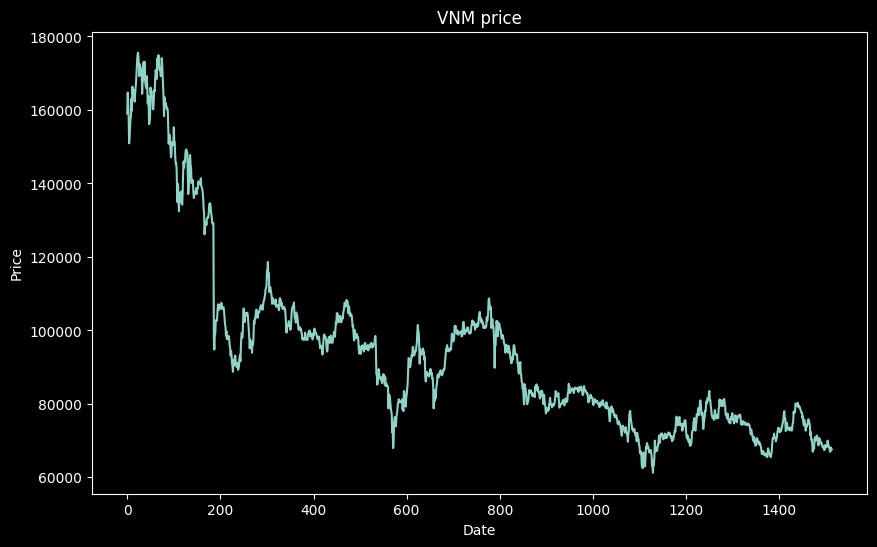

In [49]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_VNM)
plt.title('VNM price')
plt.show()

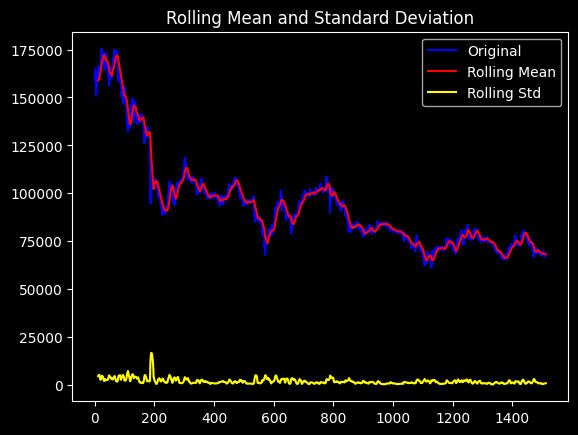

Results of dickey fuller test
Test Statistics                  -2.360615
p-value                           0.153162
No. of lags used                  0.000000
Number of observations used    1513.000000
critical value (1%)              -3.434679
critical value (5%)              -2.863452
critical value (10%)             -2.567788
dtype: float64


In [50]:
test_stationarity(close_VNM)

## Train, test

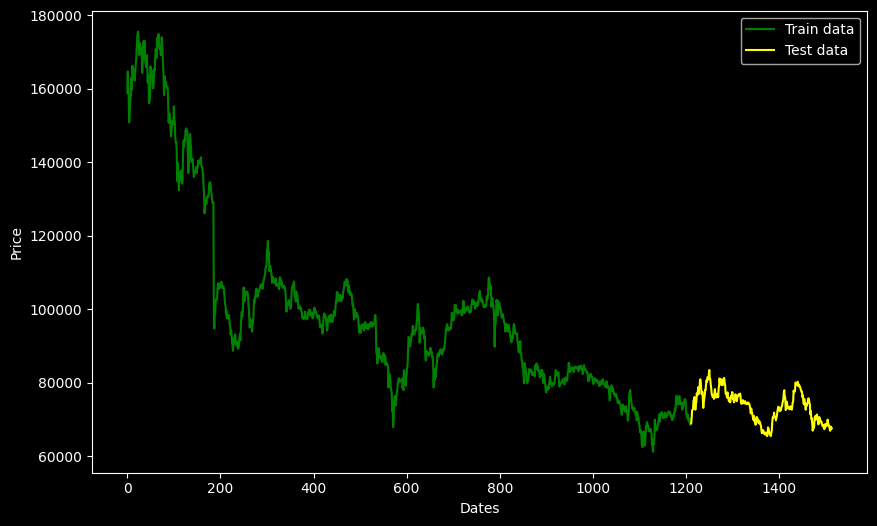

In [51]:
close_VNM = close_VNM.reset_index(drop=True)

train_data, test_data = train_test(close_VNM)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_VNM[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31388.551, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21723.218, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=21724.879, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=21725.481, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=28495.164, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=21726.661, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21723.826, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.758 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1211
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10858.609
Date:                Sat, 23 Dec 2023   AIC                          21723.218
Time:                        11:56:57   BIC                          21738.515
Sample:                             0   HQIC                         21728.978
                               - 1211                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   3798.519      0.000       0.999       1.000
ma.L1         -0.0030      0.021     -0.139      0.890      -0.045       0.039
sigma2       3.53e+06    3.2e-10    1.1e+16      0.000    3.53e+06    3.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            223047.49
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -3.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        69.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+32. Standard errors may be unstable.
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1),exog=df_VNM[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1211
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9501.006
Date:                Sat, 23 Dec 2023   AIC                          19016.012
Time:                        11:56:57   BIC                          19051.706
Sample:                             0   HQIC                         19029.452
                               - 1211                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -87.8731     60.305     -1.457      0.145    -206.069      30.323
High           0.8212      0.012     71.044      0.000       0.799       0.844
Open          -0.6100      0.013    -48.678      0.000      -0.635      -0.585
Low            0.7890      0.011     74.512      0.000       0.768       0.810
ar.L1         -0.9031      0.046    -19.619      0.000      -0.993      -0.813
ma.L1          0.8580      0.052     16.434      0.000       0.756       0.960
sigma2      3.682e+05      0.030   1.22e+07      0.000    3.68e+05    3.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               771.63
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.18e+23. Standard errors may be unstable.
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_VNM[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [56]:
eval(y_test,y_pred)

MAPE:  0.5107757623191777
RMSE:  502.40418673993804
MDE:  75.49668874172185


## Forecast

In [57]:
last_index =  close_VNM.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_VNM[['High','Open','Low']][last_index-333:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1514    69776.462676
1515    69001.543802
1516    68620.246842
1517    71401.248554
1518    70545.751776
1519    69585.223905
1520    69540.022624
1521    69257.003989
1522    69603.375354
1523    68937.322386
1524    67980.269259
1525    67989.373778
1526    67877.901813
1527    68432.540403
1528    67780.237866
1529    68096.699033
1530    69165.166536
1531    68255.978337
1532    68433.409090
1533    67697.250624
1534    68746.337923
1535    69949.804307
1536    69216.251900
1537    68421.698512
1538    68575.659939
1539    68189.405171
1540    67237.055544
1541    66637.830050
1542    67908.066319
1543    68072.361020
Name: predicted_mean, dtype: float64


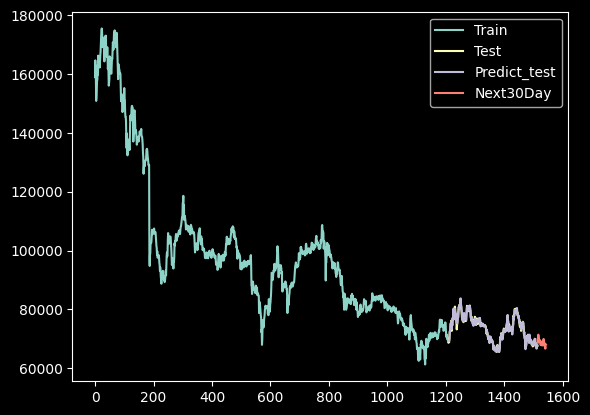

In [58]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()